# Analysis of UK Military Export Licences

## Dependencies

A note on Dependencies:
The following versions were used in the creation of this notebook, functionality cannot be garunteed on other versions.

Python 3.12.3  
Numpy 2.0.1  
Pandas 2.2.2  
Matplotlib 3.9.2  
seaborn 0.13.2  
ipykernel 6.29.5

In [47]:
#Note that imports (other than pyplot) are un-aliased. This is due to personal preference.
import numpy
import pandas
import matplotlib
import matplotlib.pyplot as pyplot
import seaborn


In [48]:
print(numpy.__version__)
print(pandas.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)


2.0.1
2.2.2
3.9.2
0.13.2


## Data Import

A note on the data: The data below is provided by the Campaign Against Arms Trade and is covered by an [Open Government Licence](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)  
The original data (updated quarterly) can be found on [CAAT's Github page](https://github.com/caatdata/uk-arms-export-data) and further information regarding the data can be found [here](https://caat.org.uk/data/exports-uk/faq).
While the data covers the complete period of 2008-2023, 2023 is incomplete due to approxamately 15% of export data being stored in a different, not publically accessible, database in preperation 

In [49]:
seaborn.set_palette('pastel')
seaborn.set_style('whitegrid',{
    'xtick.bottom':True,
    'ytick.left':True,
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.edgecolor': '.15'
    })

In [50]:
#This is the raw data from CAAT
items = pandas.read_csv('data/uk-arms-export-data-2024-06-13/items.csv')
ratings = pandas.read_csv('data/uk-arms-export-data-2024-06-13/ratings.csv')
values = pandas.read_csv('data/uk-arms-export-data-2024-06-13/values.csv')
refusal_criteria = pandas.read_csv('data/uk-arms-export-data-2024-06-13/refusal-criteria.csv')
trade_sources = pandas.read_csv('data/uk-arms-export-data-2024-06-13/trade-sources.csv')
incorporation_destinations = pandas.read_csv('data/uk-arms-export-data-2024-06-13/incorporation-destinations.csv')
footnotes_region = pandas.read_csv('data/uk-arms-export-data-2024-06-13/footnotes-region.csv')
footnotes_licence = pandas.read_csv('data/uk-arms-export-data-2024-06-13/footnotes-licence.csv')

#This list of iso codes is used to cross reference the continents and regions for categorisation later.
iso_codes = pandas.read_csv('data/iso-codes.csv')
#some modification of this file was needed to fill in entries which had iso codes that didn't appear in the list.

C:\Users\swyat\AppData\Local\Temp\ipykernel_13148\3816838328.py:2: DtypeWarning: Columns (8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  items = pandas.read_csv('data/uk-arms-export-data-2024-06-13/items.csv')
C:\Users\swyat\AppData\Local\Temp\ipykernel_13148\3816838328.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  values = pandas.read_csv('data/uk-arms-export-data-2024-06-13/values.csv')


The column 'unused' only contains a link to a question asked in the house of commons regarding a specific licence (cohort id 63207). I have dropped these columns as they contain no data, the question and answer has been taken into account. As such the licence in question, while it remains in the dataset, has been removed from some calculations as it is known that the licence was surrendered before any goods were shipped.

In [51]:

items.drop(columns='unused',inplace=True)
values.drop(columns='unused',inplace=True)

In [52]:
items['datetime'] = pandas.to_datetime(items['date'])
values['datetime'] = pandas.to_datetime(values['date'])

The following two cells were used to generate a collumn indicating the current prime-minister for each entry. However due to the length of time ths process takes, the result has been saved out as it's own csv file to be merged with the original frame, saving time on future runs.

In [53]:
# pm_time_dict = {'sunak':pandas.to_datetime('2022-10-25',format='%Y-%m-%d'),
#                 'truss':pandas.to_datetime('2022-09-06',format='%Y-%m-%d'),
#                 'johnson':pandas.to_datetime('2019-07-24',format='%Y-%m-%d'),
#                 'may':pandas.to_datetime('2016-07-13',format='%Y-%m-%d'),
#                 'cameron':pandas.to_datetime('2010-05-06',format='%Y-%m-%d')}

# def get_pm(date):
#     if date < pm_time_dict['cameron']:
#         return 'Brown'
#     elif date < pm_time_dict['may']:
#         return 'Cameron'
#     elif date < pm_time_dict['johnson']:
#         return 'May'
#     elif date < pm_time_dict['truss']:
#         return 'Johnson'
#     elif date < pm_time_dict['sunak']:
#         return 'Truss'
#     else:
#         return 'Sunak'


In [54]:
# items['prime_minister'] = items['datetime'].apply(get_pm)
# values['prime_minister'] = values['datetime'].apply(get_pm)


In [55]:
#items[['prime_minister']].to_csv('data/prime-ministers.csv',index=False)

In [56]:
#remerging the information generated above from a saved file, to save on time when re-running the notebook
pm_frame = pandas.read_csv('data/prime-ministers-items.csv')
items = items.merge(right=pm_frame,left_index=True,right_index=True)
pm_frame = pandas.read_csv('data/prime-ministers-values.csv')
values = values.merge(right=pm_frame,left_index=True,right_index=True)
del pm_frame

## Initial Analysis

The graph below shows the total number of granted licences over time. Changes in Prime Minister are marked. It appears the rate at which export licences are granted stays aproximately steady between different governments. There does appear to be a slight uptick between Brown and Cameron's governments around 2010, there is also a slight drop in 2020, likely due to covid restricts slowing down processes.

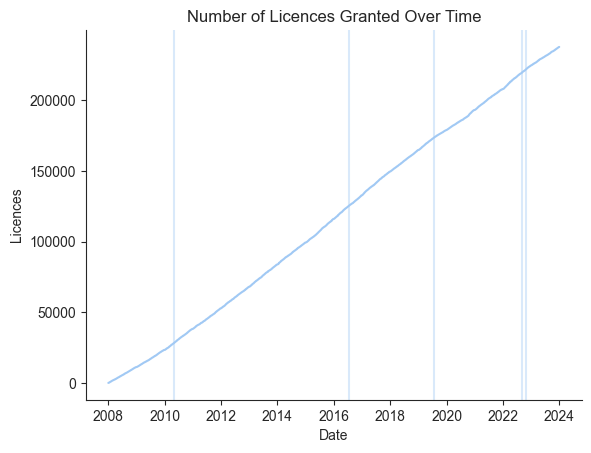

In [57]:
overtime = items[items['refused'] != 1][['licence_id','datetime']].copy()
overtime.drop_duplicates('licence_id',inplace=True)
overtime.reset_index(drop=True,inplace=True)
overtime.drop_duplicates('datetime',keep='last',inplace=True)
with seaborn.axes_style('white',{
        'xtick.bottom':True,
        'ytick.left':True,
        }):
    figure = seaborn.lineplot(data=overtime,x='datetime',y='licence_id')
    #these add lines indicating changes in prime-minister.
    figure.axvline(pandas.to_datetime('2010-05-06',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2016-07-13',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2019-07-24',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2022-09-06',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2022-10-25',format='%Y-%m-%d'),alpha = 0.4)
    figure.set(xlabel='Date',ylabel='Licences',title='Number of Licences Granted Over Time')
    seaborn.despine()
del overtime
del figure


This graph shows the cumulative value of licences granted over time. Again changes in Prime-Minister are marked. Values are not adjusted for inflation.  
Values only show the value of the granted export licences, not the actual value of goods exported, as such the total value of goods exported may be lower. Also values only include standard licences, open licences allowing an unlimited amount of exports are not included.  
The licence with cohort id 63207 has been removed from this graph. This is due to the fact that the licence was granted but surrendered without any goods being transfered. Since it was worth over £7billion (it was infact the largest single value of any licence granted) this had a noticable effect on the graph.

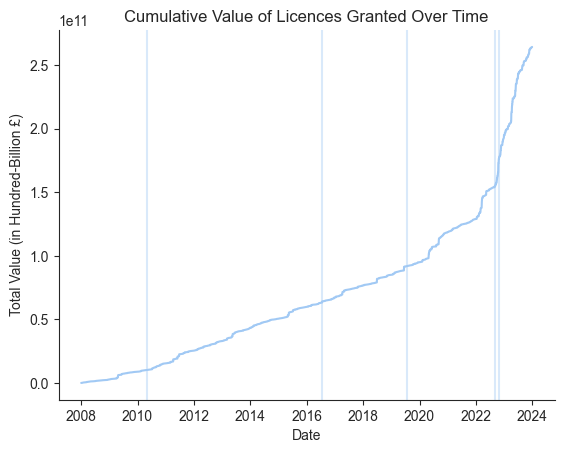

In [58]:
valueovertime = values[values['licence_cohort_id']!=63207][['datetime','value']].groupby('datetime').sum().copy().reset_index()
valueovertime['cumulative'] = valueovertime['value'].cumsum()
with seaborn.axes_style('white',{
        'xtick.bottom':True,
        'ytick.left':True,
        }):
    figure2 = seaborn.lineplot(data=valueovertime,x='datetime',y='cumulative')
    figure2.axvline(pandas.to_datetime('2010-05-06',format='%Y-%m-%d'),alpha = 0.4)
    figure2.axvline(pandas.to_datetime('2016-07-13',format='%Y-%m-%d'),alpha = 0.4)
    figure2.axvline(pandas.to_datetime('2019-07-24',format='%Y-%m-%d'),alpha = 0.4)
    figure2.axvline(pandas.to_datetime('2022-09-06',format='%Y-%m-%d'),alpha = 0.4)
    figure2.axvline(pandas.to_datetime('2022-10-25',format='%Y-%m-%d'),alpha = 0.4)
    figure2.set(xlabel='Date',ylabel='Total Value (in Hundred-Billion £)',title='Cumulative Value of Licences Granted Over Time')
    seaborn.despine()
del valueovertime
del figure2

In [59]:
#getting the number of days each prime-minister was in office as a dictionary for easy use later.
pm_days = {
    'Sunak':(pandas.to_datetime('2023-12-31',format='%Y-%m-%d') - pandas.to_datetime('2022-10-25',format='%Y-%m-%d')).days,
    'Truss':(pandas.to_datetime('2022-10-25',format='%Y-%m-%d') - pandas.to_datetime('2022-09-06',format='%Y-%m-%d')).days,
    'Johnson':(pandas.to_datetime('2022-09-06',format='%Y-%m-%d') - pandas.to_datetime('2019-07-24',format='%Y-%m-%d')).days,
    'May':(pandas.to_datetime('2019-07-24',format='%Y-%m-%d') - pandas.to_datetime('2016-07-13',format='%Y-%m-%d')).days,
    'Cameron':(pandas.to_datetime('2016-07-13',format='%Y-%m-%d') - pandas.to_datetime('2010-05-06',format='%Y-%m-%d')).days,
    'Brown':(pandas.to_datetime('2010-05-06',format='%Y-%m-%d') - pandas.to_datetime('2008-01-01',format='%Y-%m-%d')).days
}

pm_totals = pandas.DataFrame({'licences':items[items['refused']!=1].drop_duplicates('licence_id').groupby('prime_minister')['licence_id'].count()})
pm_totals['days'] = pm_days
pm_totals['licences_per_day'] = (pm_totals['licences'] / pm_totals['days']).round()

pm_totals['value'] = values[values['licence_cohort_id']!=63207].groupby('prime_minister')['value'].sum()
pm_totals['value_per_day'] = (pm_totals['value'] / pm_totals['days']).round()

del pm_days

The following graphs show the total number of Licences granted under each Prime Minister, as well as the total value of all Licences granted under each. Naturally however, since each government lasted a different length of time this isn't that useful on it's own.

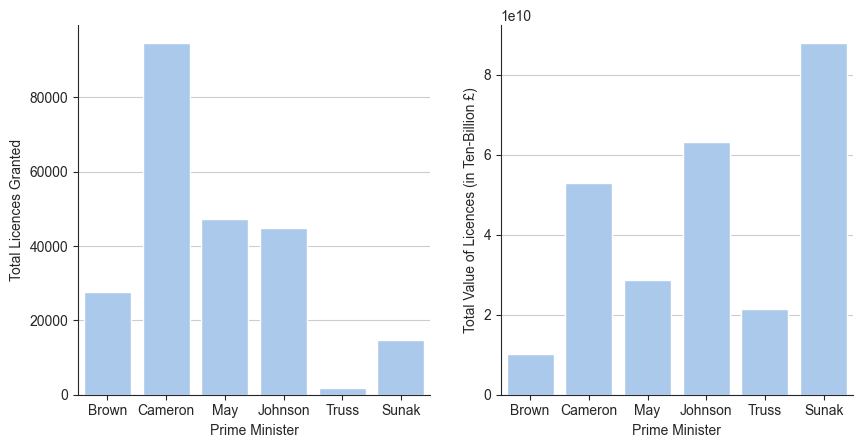

In [60]:
figure, ax = pyplot.subplots(1,2)
seaborn.barplot(data=pm_totals,y='licences',x='prime_minister',order=['Brown','Cameron','May','Johnson','Truss','Sunak'],ax=ax[0])
seaborn.barplot(data=pm_totals,y='value',x='prime_minister',order=['Brown','Cameron','May','Johnson','Truss','Sunak'],ax=ax[1])
figure.set(figwidth=10)
ax[0].set(xlabel='Prime Minister',ylabel='Total Licences Granted')
ax[1].set(xlabel='Prime Minister',ylabel='Total Value of Licences (in Ten-Billion £)')
del figure
del ax

Here are the number of licences granted and their value per day. Due to Liz Truss's historically short premiership the Value per day is clearly misleading.  
This also confirms the uptick seen between Brown and Cameron seen in the earlier total graph, fewer licences were granted under Brown relative to the length of his premiership.  


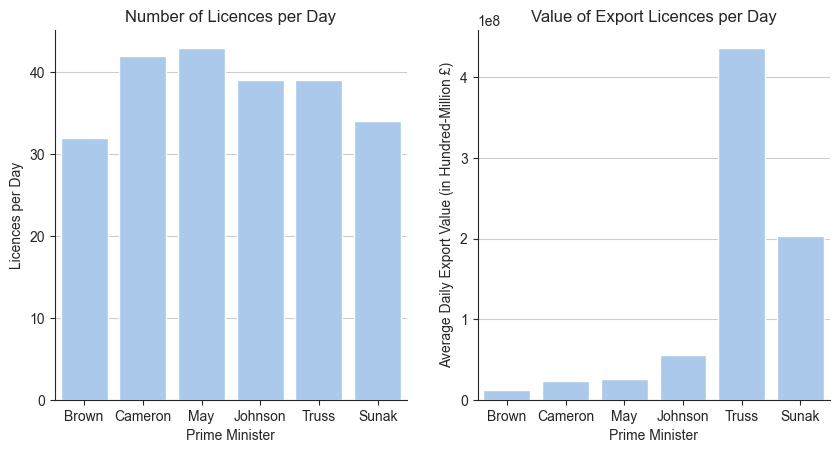

In [61]:
figure, ax = pyplot.subplots(1,2)
seaborn.barplot(data=pm_totals,y='licences_per_day',x='prime_minister',order=['Brown','Cameron','May','Johnson','Truss','Sunak'],ax=ax[0])
ax[0].set(ylabel='Licences per Day',xlabel='Prime Minister',title='Number of Licences per Day')
seaborn.barplot(data=pm_totals,y='value_per_day',x='prime_minister',order=['Brown','Cameron','May','Johnson','Truss','Sunak'],ax=ax[1])
ax[1].set(ylabel='Average Daily Export Value (in Hundred-Million £)',xlabel='Prime Minister',title='Value of Export Licences per Day')
figure.set(figwidth=10)
del figure
del ax

## The Spike

The graph showing overall value of export licences has a clear increase starting around 2022. I want to investigate possible causes of that. The first one that comes to mind is the full scale invasion of Ukraine by Russia that began Febuary 24th 2022, as part of the ongoing conflict between the two countries that started in 2014.  
To identify if this is a cause I will divide the data up into 2 year periods, and establish how the value exports to Ukraine changes over time.

In [62]:
spike_df = values[['licence_cohort_id','datetime','date','destination','value','rating','regulation','iso2']].copy()

#function to collapse years into smaller 2 year periods to aid with visualisation.
def get_period(date):
    year = int(date.split('-')[0])
    match year % 2:
        case 0:
            return f"{year}/{str(year+1)[2:]}"
        case 1:
            return f"{year-1}/{str(year)[2:]}"
        case _:
            return 'null'

spike_df['period'] = spike_df['date'].apply(get_period)
spike_df['is_ukraine'] = spike_df['destination']== 'Ukraine'


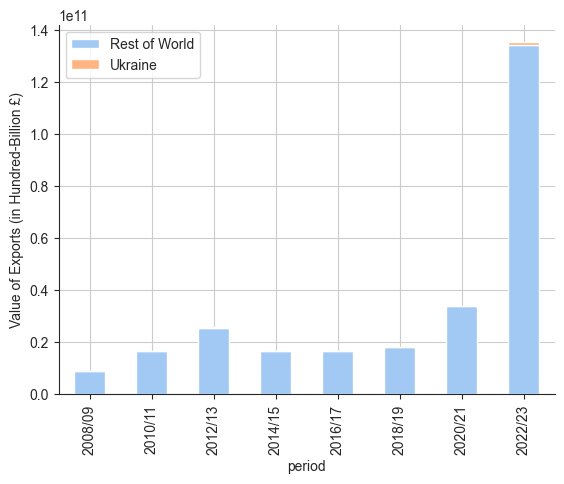

In [63]:
data = spike_df.groupby(['period','is_ukraine'])['value'].sum().unstack()
data.rename(columns={True:'Ukraine',False:'Rest of World'},inplace=True)
figure = data.plot(kind='bar',stacked=True)
figure.set(ylabel='Value of Exports (in Hundred-Billion £)')
figure.legend(title="")
del figure

This graph, upon which only a sliver of orange can be seen atop 2022/23, would indicate that the war in Ukraine is not responsible for the massive increase in the value of export licences granted in the 2022/23 period.  
The dataframe below does show that there is a boost to the % of export value to Ukraine in both the 2014/15 and 2022/23 periods (major offensives during the overarching conflict) it is not nearly enough to account for the increase in export value in 2022/23.

In [64]:
data['percentage'] = round((data['Ukraine']/(data['Ukraine']+data['Rest of World']))*100,2)
data


is_ukraine,Rest of World,Ukraine,percentage
period,,,
2008/09,8829078216,7708860,0.09
2010/11,16563356026,9243027,0.06
2012/13,25695167921,26404755,0.10
2014/15,16488171699,36226768,0.22
2016/17,16737738229,23382231,0.14
2018/19,18261359982,23923582,0.13
2020/21,34026169171,10186760,0.03
2022/23,134444234461,873965538,0.65


In [65]:
del data
spike_df.drop(columns='is_ukraine',inplace=True)

In [66]:
mask = spike_df['period'] == '2022/23'
countries22 = pandas.DataFrame(spike_df[mask].groupby('destination')['value'].sum().sort_values(ascending=False))
countries22['percent'] = ((countries22['value']/countries22['value'].sum())*100).round(2)
countries22.head(10)
del mask


In [67]:

top5_22 = countries22.index.values[:5]

It would appear China made up the largest single share of export licence value in the 2022/23 period.  

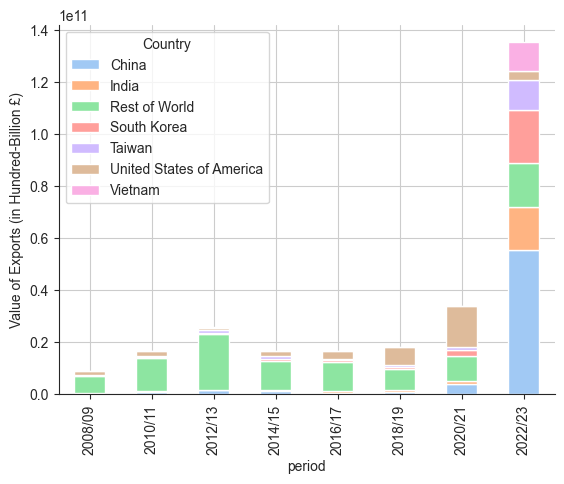

In [68]:
#collects all countries that weren't in the top 5 for 2022/23 (or the US) into a 'rest of world' category
def simplify_dest(entry):
    if entry in top5_22 or entry == 'United States of America':
        return entry
    else:
        return 'Rest of World'

spike_df['destination_simp'] = spike_df['destination'].apply(simplify_dest)
data = spike_df.groupby(['period','destination_simp'])['value'].sum().unstack()
figure = data.plot(kind='bar',stacked=True)
figure.set(ylabel='Value of Exports (in Hundred-Billion £)')
figure.legend(title='Country')
del figure
del top5_22
del countries22
del data

This graph shows the top 5 countries values  for 2022/23 throughout the different periods, as well as the United States. This shows a clear increase in trade with Asian countries, which may well be a result of brexit limiting trade with Europe, while opening it up to the rest of the world.  

In [69]:
spike_df = spike_df.merge(right=iso_codes[['region','continent','ISO (2)']],left_on='iso2',right_on='ISO (2)',how='left')

While Asia has always been an important export location, this graph shows that it grew by far more than other areas during the 2022/23 period. With Europe and the America's remaining relatively steady.

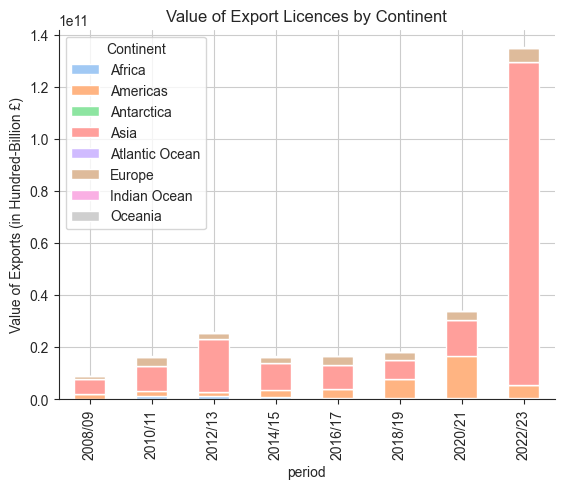

In [70]:
data = spike_df.groupby(['period','continent'])['value'].sum().unstack()
figure = data.plot(kind='bar',stacked=True)
figure.set(ylabel='Value of Exports (in Hundred-Billion £)',title='Value of Export Licences by Continent')
figure.legend(title='Continent')
del data
del figure

Furthermore, by focusing only on export licences to Asia and dividing by region, it is clear that East Asia is responsible for the majority of that growth, with some addition exports to South and Southeast, previously it had been more evenly split between South West and East Asia

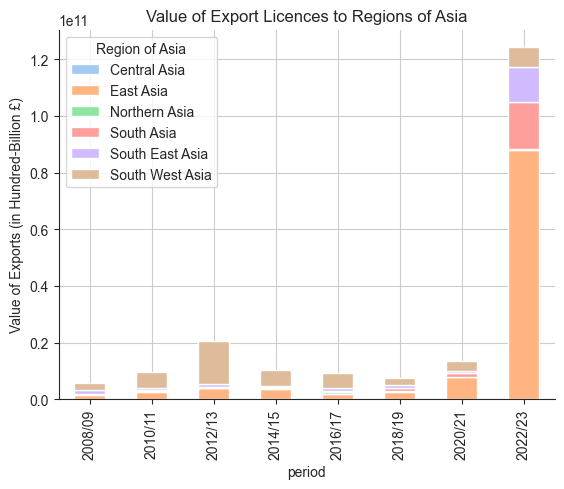

In [71]:
data = spike_df[spike_df['continent'] == 'Asia'].groupby(['period','region'])['value'].sum().unstack()
figure = data.plot(kind='bar',stacked=True)
figure.set(ylabel='Value of Exports (in Hundred-Billion £)',title='Value of Export Licences to Regions of Asia')
figure.legend(title='Region of Asia')
del data
del figure

From this it is clear that the recent increas in the value of export licences is primarily due to increased trade with Asian, specifically East Asian, countries.

In [72]:
china_value_df = spike_df[(spike_df['destination']== 'China')&(spike_df['period']=='2022/23')]
display(pandas.DataFrame(china_value_df.groupby('regulation')['value'].sum()))
display(pandas.DataFrame(china_value_df.groupby('rating')['value'].sum().sort_values(ascending=False)).head())

,value
regulation,
dual-use,55343295337
military,23826568
torture,34610


,value
rating,
5A002,34002746882
5D002,20667393173
7A103,238332189
9B001,75640000
1C240,49500000


It seems the vast majority of the value of standard export licences to China in this period come from dual-use purposed (equipment that may be used for military or civillian purpose) with most of it being rating 5A002 or 5D002, both of which refer to Telecommunications and Information Security Equiptment and Software.

In [73]:
temp_list = list(china_value_df[(china_value_df['rating']=='5A002')|(china_value_df['rating']=='5D002')]['licence_cohort_id'].drop_duplicates())
china_export_types_2022 = items[items['licence_cohort_id'].isin(temp_list)]
del temp_list

In [74]:
china_export_types_2022[['licence_id','licence_cohort_id','date','item','implicit_rating']].sample(5)
# note implicit_ratings other than 5A002 and 5D002 may appear in this list, this is because the values and items tables are connected by Licence_Cohort_Id rather than Licence_ID
# this means some licences that were part of the same cohort but had diferent ratings may appear in this list.

,licence_id,licence_cohort_id,date,item,implicit_rating
490716,211312,190453,2022-03-08,information security equipment,5A002
499870,214776,193506,2022-05-16,information security equipment,5A002
562098,232795,209477,2023-08-22,information security equipment,5A002
548826,228267,205477,2023-04-11,information security equipment,5A002
484800,209292,188645,2022-01-31,information security equipment,5A002


In [75]:
del china_export_types_2022


In [76]:
del spike_df

## Standard vs Open Licences

When looking at the value of licences we have been exclusively looking at standard export licences. This is because such licences only allow the holder to export up to the fixed value of the licence. The other type of licence, the open export licence, has no such limit to the value the holder can export. While we do not know the actual value of goods exported under a standard licence, an open licence doesn't even give us a fixed maximum value. Despite this, or perhaps even because of this, it is worth having a look at the split between these licence types now.  
  
Note that in this section we will be talking about item covered by licences, rather than the individual licences themselves. This is because it is common practice for standard licences to only cover one item, while open licences are more likely to cover multiple item types in the same licence. (for example a single open licence may cover Mine Detecting Equiptment, and components for mine detecting equipment, while a standard licence may require a seperate licence for each)

In [77]:
licence_type_df = items[items['refused']!=1][['licence_id','licence_cohort_id','date','datetime','type','destination','iso2','implicit_rating','implicit_regulation','item']]

#Simplifies licence down to open or not. This is because there are some sub-categories of standard and open licences, but we aren't interested in those right now.
def get_open(licence):
    if licence[0] == 'O':
        return True
    else:
        return False
licence_type_df['open'] = licence_type_df['type'].apply(get_open)

open_percent = round((licence_type_df[licence_type_df['open']==True]['open'].count()/licence_type_df['open'].count())*100,2)
print(f"{open_percent}% of granted licences are open.")
del open_percent

49.34% of granted licences are open.


In [78]:
open_overtime = licence_type_df[['licence_id','open','datetime']].copy()
open_overtime['standard_count']=pandas.get_dummies(open_overtime[open_overtime['open']==False]['open']).cumsum()
open_overtime['open_count']=pandas.get_dummies(open_overtime[open_overtime['open']==True]['open']).cumsum()
open_overtime.iloc[0,4]=0
open_overtime[['Standard','Open']] = open_overtime[['standard_count','open_count']].ffill()

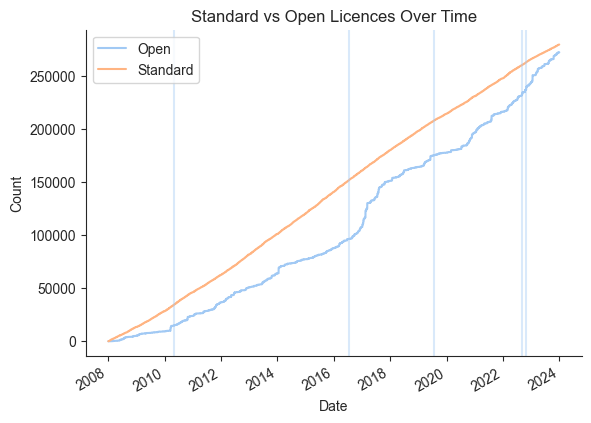

In [79]:
with seaborn.axes_style('white',{
        'xtick.bottom':True,
        'ytick.left':True,
        }):
    figure = open_overtime[['datetime','Open','Standard']].plot(kind='line',x='datetime')
    figure.axvline(pandas.to_datetime('2010-05-06',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2016-07-13',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2019-07-24',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2022-09-06',format='%Y-%m-%d'),alpha = 0.4)
    figure.axvline(pandas.to_datetime('2022-10-25',format='%Y-%m-%d'),alpha = 0.4)
    figure.set(xlabel='Date',ylabel='Count',title='Standard vs Open Licences Over Time')
    seaborn.despine()
del figure

In [80]:
del open_overtime

While the granting of standard licences stays relatively stable, with simmilar differences to overall licence counts between successive governments, open licences are much more varied. The large spike around 2017 is particularly interesting given it's proximity both to a new prime-minister (Theresa May) and being during a period of heavy Brexit negotiations. Next we should take a look at the destinations of these open licences.

In [81]:
licence_type_df['year'] = licence_type_df['date'].apply(lambda s: s.split("-",1)[0])

In [82]:
licence_type_df = licence_type_df.merge(right=iso_codes[['region','continent','ISO (2)']],left_on='iso2',right_on='ISO (2)',how='left')

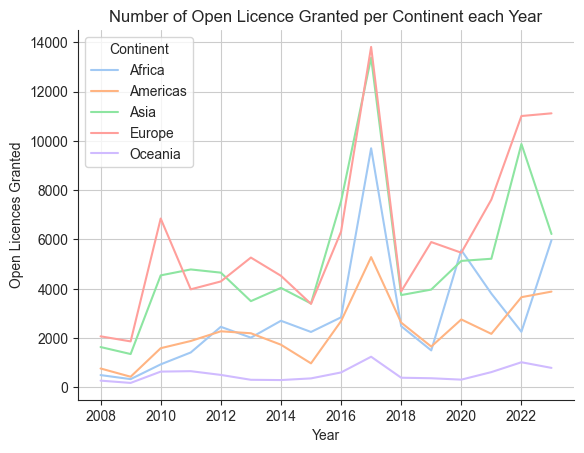

In [83]:
continent_mask = (licence_type_df['continent']!='Antarctica') & (licence_type_df['continent']!='Indian Ocean') & (licence_type_df['continent']!='Atlantic Ocean')
figure = licence_type_df[(licence_type_df['open']==True) & continent_mask].groupby(['year','continent'])['open'].count().unstack().plot(kind='line')
figure.set(xlabel='Year',ylabel='Open Licences Granted',title='Number of Open Licence Granted per Continent each Year')
figure.legend(title='Continent')
del figure
del continent_mask

This chart showing the number of open licence granted per year shows a dramatic spike in 2017. While this could be due to a change in policy within Theresa May's government, it is most likely that this is in response to Brexit, as more companies scramble for export licences either within Europe, or to diversify their customer base in the face of losing easy access to the EU market. It is noteable that aside from 2023, open export licences for both Europe and Asia stay relatively close.

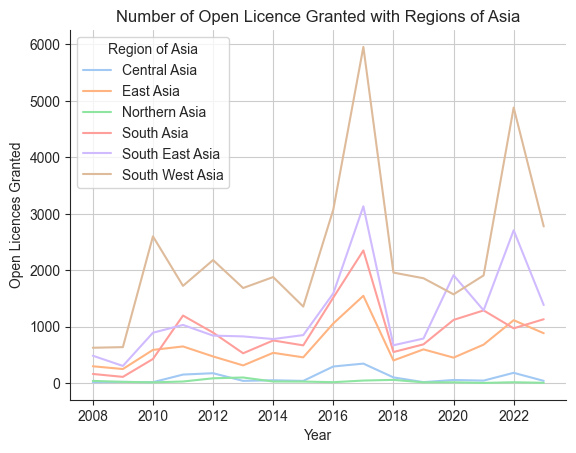

In [84]:
figure = licence_type_df[(licence_type_df['open']==True) & (licence_type_df['continent'] == 'Asia')].groupby(['year','region'])['open'].count().unstack().plot(kind='line')
figure.set(xlabel='Year',ylabel='Open Licences Granted',title='Number of Open Licence Granted with Regions of Asia')
figure.legend(title='Region of Asia')
del figure

Interestingly the open licences granted in various regions of Asia show simmilar proportions each year. This is noteably since it's clear that while standard licences within East Asia increased disproportionately, open licences did not. This would imply increasing trade with, and even reliance on, this area, but lacking the more open trust the UK might have with closer allies such as Europe or America, since licences to the area are primarily in a limited form.  
It is possible that the general dip in 2023 is partly due to the previously mentioned shift to a new, opaque storage database, however it is equally possible that other factors have caused this.

In [85]:
temp = pandas.DataFrame(licence_type_df[licence_type_df['open']==True].groupby('implicit_regulation')['implicit_regulation'].count().sort_values(ascending=False))
temp['percentage'] = round((temp['implicit_regulation']/temp['implicit_regulation'].sum())*100,2)
display(temp)

temp = pandas.DataFrame(licence_type_df[licence_type_df['open']==True].groupby('implicit_rating')['implicit_rating'].count().sort_values(ascending=False))
temp['percentage'] = round((temp['implicit_rating']/temp['implicit_rating'].sum())*100,2)
display(temp.head(5))
del temp

,implicit_regulation,percentage
implicit_regulation,,
military,232505,85.28
dual-use,40110,14.71
torture,17,0.01


,implicit_rating,percentage
implicit_rating,,
ML10,55437,20.33
ML22,41582,15.25
ML1,27732,10.17
ML11,19057,6.99
ML21,10600,3.89


Surprisingly around 85% of all open licences are for military purposem with the most common rating being ML10 or Military Aircraft, Helicopters or Drones.

In [86]:
del licence_type_df

## Export Ratings

Information regarding items are split among three entries in the data, 'Implicit Regulation' is the regulation under which the items fall, this can be one of three values. Military for items with exlusive military use, though this can also cover para-military or police equipment. Dual-use refers to items which can have military applications or civillian, for example communications equipment or chemicals fall under this regulation. Finally there is torture, this as the name suggests refers to items that could be used in torture but also have other uses, common itmes include anaesthetics or handcuffs.
'Implicit Rating' is more specific, this refers to a general grouping of items, for example small arms or military aircraft. Usually an items regulation stems from it's rating, though this may not always be the case. These ratings are used to generalise the classification of items for use in international regulations.
Finally there is a more specific 'Item' which is a more specific, often more detailed description of the items a specific licence covers. This isn't internationally recognised and is only used for British internal documentation, while more specific than the rating it is often still vague.
I wanted to finish this analysis with a quick look at the split of different regulations and ratings within granted export licences.

In [87]:
regulation_df = pandas.DataFrame(items[items['refused'] != 1].groupby('implicit_regulation')['implicit_regulation'].count())
regulation_df['percentage'] = round((regulation_df['implicit_regulation']/regulation_df['implicit_regulation'].sum())*100,2)
regulation_df
del regulation_df

Overall military regulation accounts for about 75% of all granted export licences. This is a slight drop from the 85% amongst specifically open-licences. While this could be interpreted in sinister ways it's not all that surprising. explicitly military items are much more common than items that require this kind of export licence but also have civillian use. Other civillian items requiring export licences, food, electronics or drugs for example are covered by other regulations. A more detailed breakdown of the types and amounts of military regulation equipment can be seen below.  
Again, there is nothing particularly surprising within these results. BAE Systems are a well known and large scale British exporter of military aircraft so it's not surprising that 'ML 10' would rank so highly. Ratings after that are both general and ubiquitous enough that a high nuber of export licences is not surprising.

In [88]:
military_df = pandas.DataFrame(items[ (items['refused']!=1) & (items['implicit_regulation']=='military') ].groupby('implicit_rating')['implicit_rating'].count())
military_df['percentage'] = round((military_df['implicit_rating']/military_df['implicit_rating'].sum())*100,2)
military_df.rename(columns={'implicit_rating':'count'},inplace=True)
display(military_df.sort_values('count',ascending=False).merge(right=ratings[['short_description','rating']],left_index=True,right_on='rating',how='left').set_index('rating',drop=True))
del military_df

,count,percentage,short_description
rating,,,
ML10,87925,21.37,"Aircraft, helicopters, drones"
ML1,62060,15.08,Small arms
ML22,50189,12.20,Technology
ML11,35888,8.72,Other electronic equipment
ML4,20602,5.01,"Grenades, bombs, missiles, countermeasures"
ML5,20327,4.94,"Target acquisition, weapon control and counter..."
ML13,18067,4.39,"Armoured plate, body armour, helmets"
ML6,14767,3.59,"Armoured vehicles, tanks"
ML3,14591,3.55,Ammunition


Below shows the total value of standard-licences issued for each rating as well. Again ML10 appears at the top, though ML4 has increased somewhat. This could indicate that ML4 is a highly valuable export product, or that it is more likely to require a standard, rather than an open licence. Given that it appears in the top 5 rated military licences overall, but not in the top 5 military open-licences, this would suggest the latter. 

In [89]:
military_value = pandas.DataFrame(values[(values['refused']!=1) & (values['regulation'] == 'military')][['rating','value']].groupby('rating')['value'].sum())
military_value['percentage'] = round((military_value['value']/military_value['value'].sum())*100,2)
display(military_value.sort_values('value',ascending=False).merge(right=ratings[['short_description','rating']],left_index=True,right_on='rating',how='left').set_index('rating',drop=True))

,value,percentage,short_description
rating,,,
ML10,29811265120,43.67,"Aircraft, helicopters, drones"
ML4,12092817370,17.71,"Grenades, bombs, missiles, countermeasures"
ML1,3995122487,5.85,Small arms
ML11,3777260081,5.53,Other electronic equipment
ML9,3662798796,5.37,Warships
ML5,3582805765,5.25,"Target acquisition, weapon control and counter..."
ML6,2297306777,3.37,"Armoured vehicles, tanks"
ML22,1563814648,2.29,Technology
ML15,1088500519,1.59,Imaging equipment


Items covered under dual-use regulationare a little trickier to present since there are multiple ratings covering simmilar categories of items. However below is a simmilar graph to the previous showing the number's of different rated dual-use licences. Again, there are no particularly surprising results. Generally most licences are for item's with a high number of civillian uses, but regulation is still necessary for oversight reasons.

In [90]:
def ratings_simp(entry):
    if entry[0] in "0123456789":
        return entry[0]
    else:
        return entry

ratings['rating_simp'] = ratings['rating'].apply(ratings_simp)
dual_use_df = items.copy()
dual_use_df['rating_simp'] = dual_use_df['implicit_rating'].apply(ratings_simp)
dual_use_df = pandas.DataFrame(dual_use_df[(dual_use_df['refused']!=1) & (dual_use_df['implicit_regulation'] == 'dual-use')].groupby(by='rating_simp')['rating_simp'].count())
dual_use_df['percentage'] = round((dual_use_df['rating_simp']/dual_use_df['rating_simp'].sum())*100,2)
dual_use_df.rename(columns={'rating_simp':'count'},inplace=True)
display(dual_use_df.sort_values('count',ascending=False).merge(right=ratings[['rating_simp','short_description']],left_index=True,right_on='rating_simp',how='left').set_index('rating_simp',drop=True).drop_duplicates())
del dual_use_df

,count,percentage,short_description
rating_simp,,,
5,45201,32.13,Telecommunications and information security
6,20856,14.83,Sensors and lasers
1,19133,13.60,Special materials and related equipment
2,11115,7.90,Materials processing
7,10841,7.71,Navigation and avionics
0,7810,5.55,"Nuclear materials, facilities and equipment"
3,6110,4.34,Electronics
FR AI,4644,3.30,Non-military firearms (Firearms Regulation Ann...
8,3120,2.22,Marine


# Assorted Observations

The following section contains smaller observations that were tangential to the main analysis above. It is mostly investigations of individual data-points or other miscellaneous items of note.

### 'Torture' Rating Exports to China

Noticed during my analysis of the export licences to China in 2022/23 there was a small amount of licences under the 'torture' regulation, namely materials that could potentially be used for torture. Decided to have a quick look overall at this. Turns out to be anaesthetics, there are a few other licences for similar purposes. This is likely nothing particualarly sinister.

In [91]:
temp_list = list(items[(items['implicit_regulation']=='torture') & (items['destination']=='China')]['licence_cohort_id'].drop_duplicates())
china_torture_df = items[['licence_id','licence_cohort_id','destination','date','item','quantity','implicit_rating','implicit_regulation']][items['licence_cohort_id'].isin(temp_list)].merge(right=values[['licence_cohort_id','value']],on='licence_cohort_id',how='left')
display(china_torture_df)


,licence_id,licence_cohort_id,destination,date,item,quantity,implicit_rating,implicit_regulation,value
0,199425,179838,China,2021-05-26,barbiturate anaesthetic agents for injection,NaN,HR AIV,torture,3002.0
1,200701,180964,China,2021-06-22,barbiturate anaesthetic agents for injection,NaN,HR AIV,torture,NaN
2,219847,198038,China,2022-09-08,barbiturate anaesthetic agents for injection,NaN,HR AIV,torture,34610.0


In [92]:
del china_torture_df
del china_value_df

### 'End Use' Rating

One special rating used in this dataset is 'End Use'. This is a rating that can be applied to any type of item (or software) but it indicates that there is some suspicion that the items may be used by the destination country (or a country that it will be sent to afterwards) in the development of WMDs. Naturally these items come under higher scrutiny and so export licences are refused at a much higher rate than usual, which is probably a good thing.

In [93]:
end_use_df = items[items['implicit_rating']=='End Use'].copy()
refusal_rate = round((items[items['refused']==1]['refused'].count()/items['refused'].count())*100,2)
end_use_refusal_rate = round((end_use_df[end_use_df['refused']==1]['refused'].count()/end_use_df['refused'].count())*100,2)
end_use_rate = round((end_use_df[end_use_df['refused']==1]['refused'].count()/items[items['refused']==1]['refused'].count())*100,2)

end_use_percent = round((len(end_use_df)/len(items))*100,2)

most_common_refusal = items[items['refused']==1].groupby('implicit_rating')['implicit_rating'].count().sort_values(ascending=False)
print(f"The overall refusal rate for all export licences is {refusal_rate}%, this increases to {end_use_refusal_rate}% for licences marked with the 'End Use' rating.\n")
print(f"{end_use_percent}% of export licences are marked with an 'End Use' rating but account for {end_use_rate}% of all refusals.\n")
print(f"The most common rating of a refused export licence is {most_common_refusal.index.values[0]} or {ratings.set_index('rating').loc[most_common_refusal.index.values[0]]['short_description']}\n")
print(f"The top 10 most common destinations for licences marked with 'End Use' rating are {str(list(end_use_df.groupby('destination')['destination'].count().sort_values(ascending=False).index[:10]))}")

del end_use_df
del refusal_rate
del end_use_refusal_rate
del end_use_rate
del end_use_percent
del most_common_refusal


The overall refusal rate for all export licences is 4.57%, this increases to 52.02% for licences marked with the 'End Use' rating.

0.54% of export licences are marked with an 'End Use' rating but account for 6.13% of all refusals.

The most common rating of a refused export licence is ML1 or Small arms

The top 10 most common destinations for licences marked with 'End Use' rating are ['Iran', 'Pakistan', 'China', 'United Arab Emirates', 'India', 'Russia', 'Turkey', 'Syria', 'Malaysia', 'Afghanistan']


# Graveyard

Below is a non-exauhstive collection of various code snippets that were used in experiments, dropped, ignored or otherwise abandoned. They have been removed from the main body of this notebook and placed here for posterity.

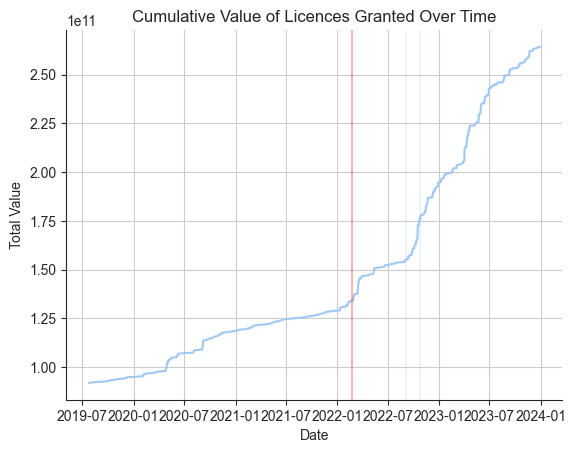

In [94]:
#graph focusing on the Johnson/Truss/Sunak switch where the major value spike occurs. Marked in red is the Russian Invasion of Ukraine on Febuary 24th 2022.
valueovertime = values[values['licence_cohort_id']!=63207][['datetime','value']].groupby('datetime').sum().copy().reset_index()
valueovertime['cumulative'] = valueovertime['value'].cumsum()
figure = seaborn.lineplot(data=valueovertime[valueovertime['datetime'] > pandas.to_datetime('2019-07-24',format='%Y-%m-%d')],x='datetime',y='cumulative')
figure.axvline(pandas.to_datetime('2022-09-06',format='%Y-%m-%d'),alpha = 0.2)
figure.axvline(pandas.to_datetime('2022-10-25',format='%Y-%m-%d'),alpha = 0.2)

figure.axvline(pandas.to_datetime('2022-02-24',format='%Y-%m-%d'),color='r',alpha=0.3)
figure.set(xlabel='Date',ylabel='Total Value',title='Cumulative Value of Licences Granted Over Time')
del valueovertime
del figure

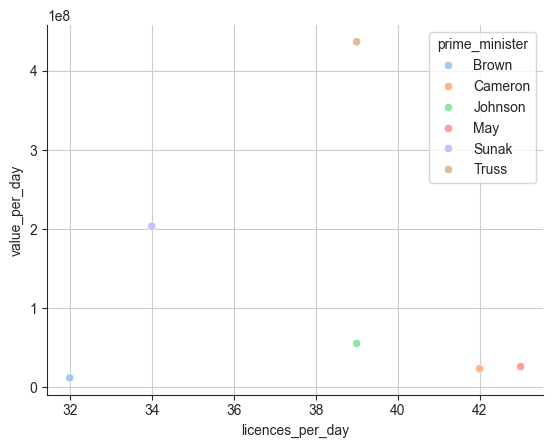

In [95]:
#doesn't appear to show anything interesting
figure = seaborn.scatterplot(data=pm_totals,x='licences_per_day',y='value_per_day',hue='prime_minister')
del figure


In [96]:
del pm_totals